In [1]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 18, 8
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

print(tf.__version__)

2.7.0


### Get our data

In [2]:
from getdata1 import *

# GET_csse_covid_19_daily_reports()
latest_data_global, prev_data_global = GET_csse_covid_19_daily_reports_my('global')
latest_data_us, prev_data_us = GET_csse_covid_19_daily_reports_my('us')

# GET_csse_covid_19_time_series()
time_series_covid19_confirmed_US, time_series_covid19_confirmed_global, time_series_covid19_deaths_US, time_series_covid19_deaths_global,time_series_covid19_recovered_global = GET_csse_covid_19_time_series_my()

# shanghai time series data
ts_shanghai_covid = GET_shanghai_data_my()

reading [cross sectional] data ......
finish reading
reading [cross sectional] data ......
finish reading
reading [time series] data ......
finish reading
reading [shanghai] data ......
finish reading


### Process data ready to use

In [3]:
from ipynb.fs.defs.process_analysis import ts_process_CHINA_my, ts_process_US_my, daily_process_my

In [4]:
ts_confirmed_CHINA_incre = ts_process_CHINA_my(time_series_covid19_confirmed_global)
ts_deaths_CHINA_incre = ts_process_CHINA_my(time_series_covid19_deaths_global)
ts_recovered_CHINA_incre = ts_process_CHINA_my(time_series_covid19_recovered_global)

ts_confirmed_US_incre = ts_process_US_my(time_series_covid19_confirmed_US,clip=False)
ts_deaths_US_incre = ts_process_US_my(time_series_covid19_deaths_US,death = True,clip=False)

latest_data_CHINA = daily_process_my(latest_data_global, country = 'China')
prev_data_CHINA = daily_process_my(prev_data_global, country = 'China')
latest_data_US = daily_process_my(latest_data_us, country = 'US')
prev_data_US = daily_process_my(prev_data_us, country = 'US')

First, take a look at New York data.
Check Autocorrelation

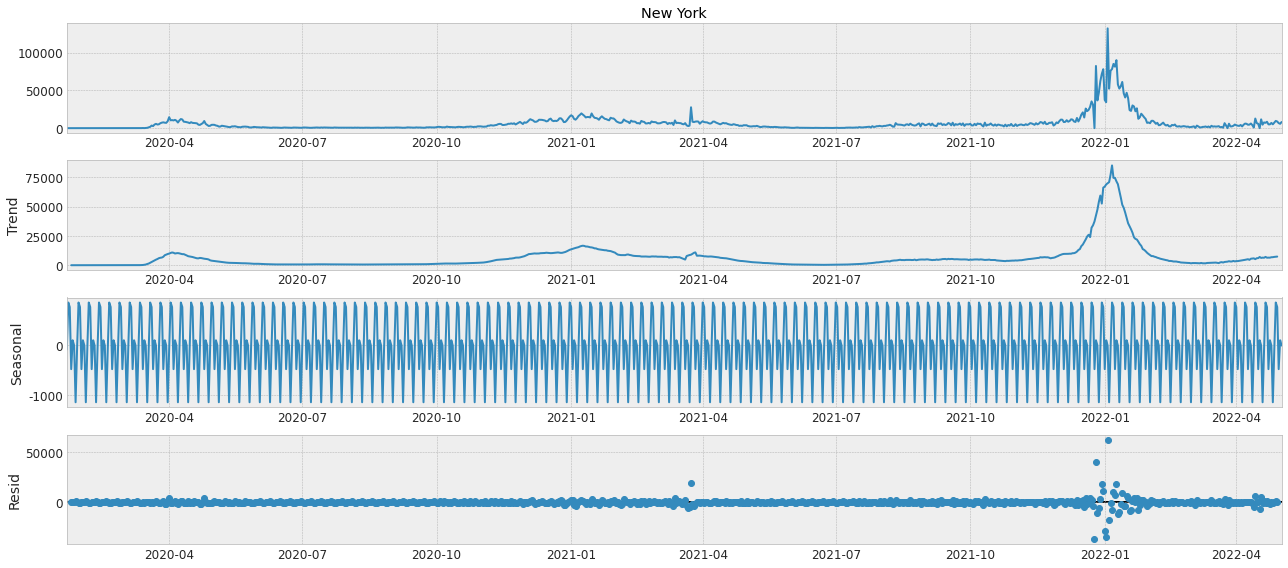

In [10]:
dcp1 = seasonal_decompose(ts_confirmed_US_incre['New York'],model='additive')

dcp1.plot()

plt.show()

In [11]:
df_reconstructed = pd.concat([dcp1.seasonal, dcp1.trend, dcp1.resid, dcp1.observed], axis=1)
df_reconstructed.columns = ['seasonal', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seasonal,trend,resid,actual_values
2020-01-22,-86.392771,NaN,NaN,0.0
2020-01-23,851.730716,NaN,NaN,0.0
2020-01-24,761.126600,NaN,NaN,0.0
2020-01-25,-478.554998,0.0,478.554998,0.0
2020-01-26,98.297302,0.0,-98.297302,0.0


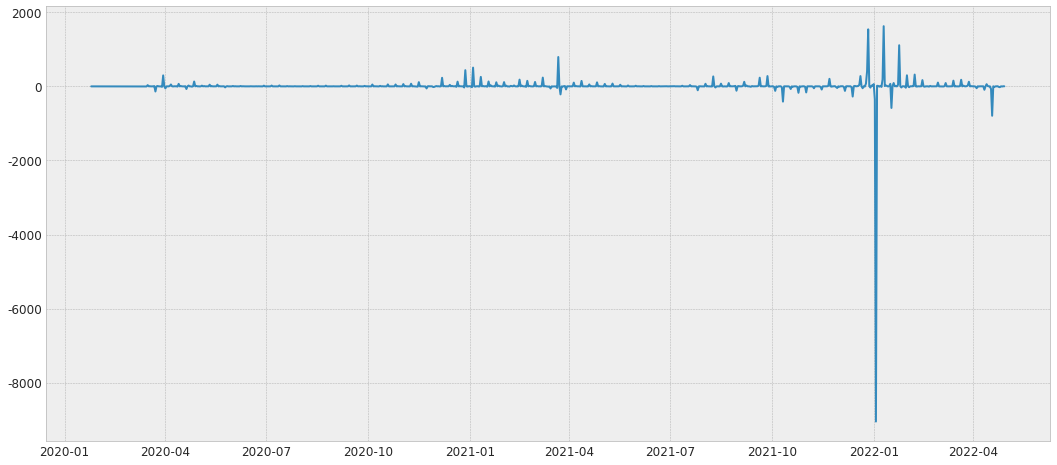

In [21]:
# detrend
detrended1 = df_reconstructed['actual_values'] - df_reconstructed['trend']

# deseasonalize
# Divide the series by the seasonal index obtained from STL decomposition
deseasonalized1 = detrended1/df_reconstructed['seasonal']

plt.plot(deseasonalized1)

##### use Unit Root tests to test for stationary
###### Augmented Dickey Fuller test (ADH Test)

In [24]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_reconstructed['actual_values'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.5559167737958206
p-value: 0.00666193570493778


In [25]:
split_date = '2022-01-01'
df_train = ts_confirmed_US_incre.loc[ts_confirmed_US_incre.index < split_date]
df_test = ts_confirmed_US_incre.loc[ts_confirmed_US_incre.index >= split_date]
print(f"{len(df_train)} days of training data \n {len(df_test)} days of testing data ")

710 days of training data 
 122 days of testing data 


In [36]:

y = df_train['New York']

freq = 1e9 / np.diff(y.index.values).min().astype(int)
freq

1.1574074074074073e-05

In [32]:
from pmdarima.arima.utils import ndiffs

y = df_train['New York']
## Adf Test
# ndiffs(y, test='adf')  #0

# KPSS test
# ndiffs(y, test='kpss')  # 2

# PP test:
ndiffs(y, test='pp')  # 0

0

### auto SARIMA model

In [40]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

sarima_mdl = pm.auto_arima(df_train['New York'],
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(sarima_mdl.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=13347.733, Time=2.80 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=14640.016, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=14145.272, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=13346.430, Time=1.96 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=13363.877, Time=0.50 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=13562.254, Time=1.14 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=13364.415, Time=2.02 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=13346.874, Time=2.12 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=13433.366, Time=1.38 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=13332.877, Time=1.95 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=13340.164, Time=1.57 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=13352.634, Time=1.59 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=13355.739, Time=3.06 sec

Best model:  ARIMA(2,2,3

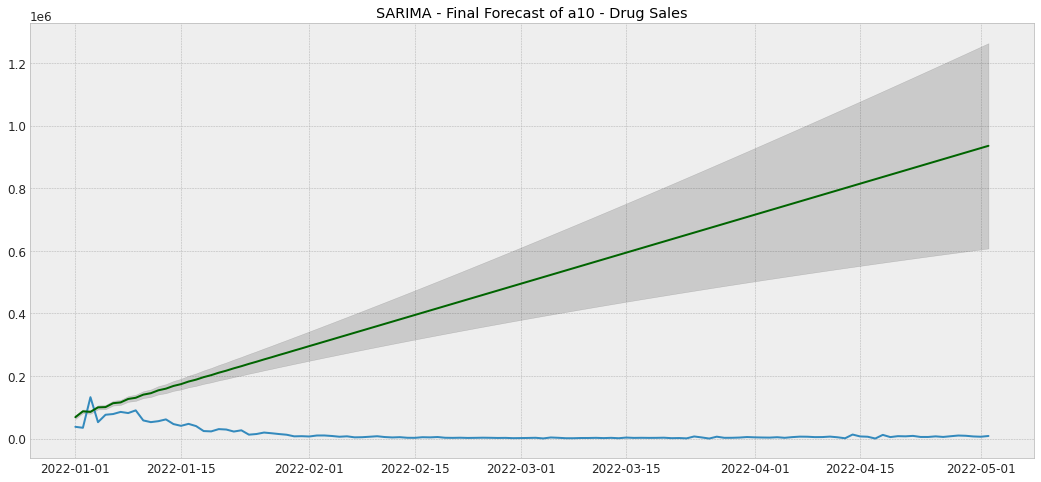

In [56]:

fitted, confint = sarima_mdl.predict(n_periods = 122, return_conf_int=True)


# make series for plotting purpose
fitted_series = pd.Series(fitted,index=df_test.index)
lower_series = pd.Series(confint[:, 0],index=df_test.index)
upper_series = pd.Series(confint[:, 1],index=df_test.index)


# Plot
# plt.plot(df_train)
plt.plot(df_test['New York'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

resources:
http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2019/02/Lecture_03.pdf
https://www.machinelearningplus.com/time-series/time-series-analysis-python/
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/v